In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from tqdm import tqdm 
from scipy import stats
from shapely.geometry import Polygon
from sklearn.metrics import auc
import sys 

sys.path.append('scripts')

from coordinates_parser import parse_coordinates
from create_image_metrics import create_image_metrics
from polygons_comparator import match_polygons

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### **Read Dataset**

In [18]:
anno_df = pd.read_csv('../data/anno_df.csv')
anno_df.head()

,Unnamed: 0,filename,image_id,id,defect_class_id,label,xy,x,y
0,0,1g_04.png,624,175683,7,Mononukleäre Zelle,"1354,1377.48,1330.52,1389.22,1330.52,1412.699,...","[1354.0, 1330.52, 1330.52, 1350.087, 1357.913,...","[1377.48, 1389.22, 1412.699, 1424.439, 1420.52..."
1,1,1g_04.png,624,175664,7,Mononukleäre Zelle,"223.058,1804.029,199.578,1800.116,191.751,1815...","[223.058, 199.578, 191.751, 203.491, 223.058, ...","[1804.029, 1800.116, 1815.769, 1831.422, 1835...."
2,2,1g_04.png,624,175634,7,Mononukleäre Zelle,"1549.665,1005.717,1545.751,1013.543,1541.838,1...","[1549.665, 1545.751, 1541.838, 1541.838, 1557....","[1005.717, 1013.543, 1021.37, 1037.023, 1037.0..."
3,3,1g_04.png,624,175654,7,Mononukleäre Zelle,"661.347,1678.803,637.867,1667.064,614.387,1674...","[661.347, 637.867, 614.387, 622.214, 630.04, 6...","[1678.803, 1667.064, 1674.89, 1698.37, 1694.45..."
4,4,1g_04.png,624,175633,7,Mononukleäre Zelle,"1784.462,1897.948,1796.202,1886.208,1804.029,1...","[1784.462, 1796.202, 1804.029, 1780.549, 1772....","[1897.948, 1886.208, 1870.555, 1858.815, 1862...."


In [19]:
pred_df = pd.read_csv('../data/pred_df.csv')
pred_df.head()

,Unnamed: 0,image_id,prediction_id,confidence,polygon_id,prediction_class,xy
0,0,3165,23699,0.431523,1937097,Defect,"37.578460693359375,13.887542724609375,37.31016..."
1,1,3165,23699,0.603884,1937098,Defect,"231.45407104492188,9.646164820744442,225.45407..."
2,2,3165,23699,0.244653,1937099,Defect,"318.3146711077009,33.736045837402344,316.76688..."
3,3,3165,23699,0.916268,1937100,Defect,"395.9158020019531,82.97906857445126,387.915802..."
4,4,3165,23699,0.366087,1937101,Defect,"337.0517883300781,84.71218928584346,332.051788..."


###  **Initial Exploration**

**1. Manually Collected (Ground Truth) — anno_df:**
- Has 3,648 entries

    Key columns:
- `image_id`: image reference
- `defect_class_id`: defect category
- `label`: readable label (e.g., "Mononukleäre Zelle")
- `x,y,xy`: coordinate data for bounding polygons (object location)

**2. Model Predictions (Generated) — pred_df:**
- Has 7,118 entries

    Key columns:
- `image_id`: to match with anno_df
- `confidence`: model's confidence for each prediction
- `prediction_class`: predicted class (e.g., "Defect")
- `xy`: predicted polygon

**Takeaways**
- We have 3,648 manual annotations vs 7,118 predictions
- No missing values
- Both datasets contain exactly 48 unique images (no missing images in either dataset)
- Single `defect_class` in anno_df and single `prediction_class` in pred_df

In [20]:
def basic_dataset_info(df, name):
    """Print basic information about the dataset"""
    print(f"\n=== {name} Dataset Analysis ===")
    print("\nBasic Info:")
    print(df.info())
    print("\nSummary Statistics:")
    print(df.describe())
    print("\nMissing Values:")
    print(df.isnull().sum())
    print("\nUnique Values:")
    print(df.nunique())

In [21]:
basic_dataset_info(anno_df, "Annotation")


=== Annotation Dataset Analysis ===

Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3648 entries, 0 to 3647
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       3648 non-null   int64 
 1   filename         3648 non-null   object
 2   image_id         3648 non-null   int64 
 3   id               3648 non-null   int64 
 4   defect_class_id  3648 non-null   int64 
 5   label            3648 non-null   object
 6   xy               3648 non-null   object
 7   x                3648 non-null   object
 8   y                3648 non-null   object
dtypes: int64(4), object(5)
memory usage: 256.6+ KB
None

Summary Statistics:
        Unnamed: 0     image_id            id  defect_class_id
count  3648.000000  3648.000000  3.648000e+03           3648.0
mean   1823.500000  1952.283717  9.417104e+05              7.0
std    1053.231219   831.767822  5.353460e+05              0.0
min       0.000000 

In [22]:
basic_dataset_info(pred_df, "Prediction")


=== Prediction Dataset Analysis ===

Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7118 entries, 0 to 7117
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        7118 non-null   int64  
 1   image_id          7118 non-null   int64  
 2   prediction_id     7118 non-null   int64  
 3   confidence        7118 non-null   float64
 4   polygon_id        7118 non-null   int64  
 5   prediction_class  7118 non-null   object 
 6   xy                7118 non-null   object 
dtypes: float64(1), int64(4), object(2)
memory usage: 389.4+ KB
None

Summary Statistics:
        Unnamed: 0     image_id  prediction_id   confidence    polygon_id
count  7118.000000  7118.000000    7118.000000  7118.000000  7.118000e+03
mean   3558.500000  1951.781540   23720.931863     0.512246  1.940022e+06
std    2054.933941   813.485715      14.282011     0.302539  2.054934e+03
min       0.000000   624.000000   2

#### **Integrity & Overlap Checks**

**image_ids alignment across datasets**
- Every single image has more predictions than annotations
- On average, there are 1.95 predictions for every annotation
- The difference ranges from as low as 2 extra predictions (image 2323) to as high as 183 extra predictions (image 2879)
- Notable Cases:
    - Lowest annotation count: Image 653 (8 annotations, 14 predictions)
    - Highest annotation count: Image 3161 (228 annotations, 353 predictions)
    - Most over-predicted: Image 2879 (183 more predictions than annotations)
    - Most closely matched: Image 2323 (only 2 more predictions than annotations)

**Confidence Score Distribution:**
- Median confidence is 0.47
- 25% of predictions have confidence > 0.82
- All predictions have at least 0.10 confidence
- The predictions have confidence scores ranging from 0.10 to 0.99, with a mean of 0.51
- There's significant variation in confidence scores

**Insights:**
- The model is over-predicting defects (about twice as many predictions as ground truth)
- The over-prediction is consistent across all images
- There's significant variation in how many extra predictions are made per image


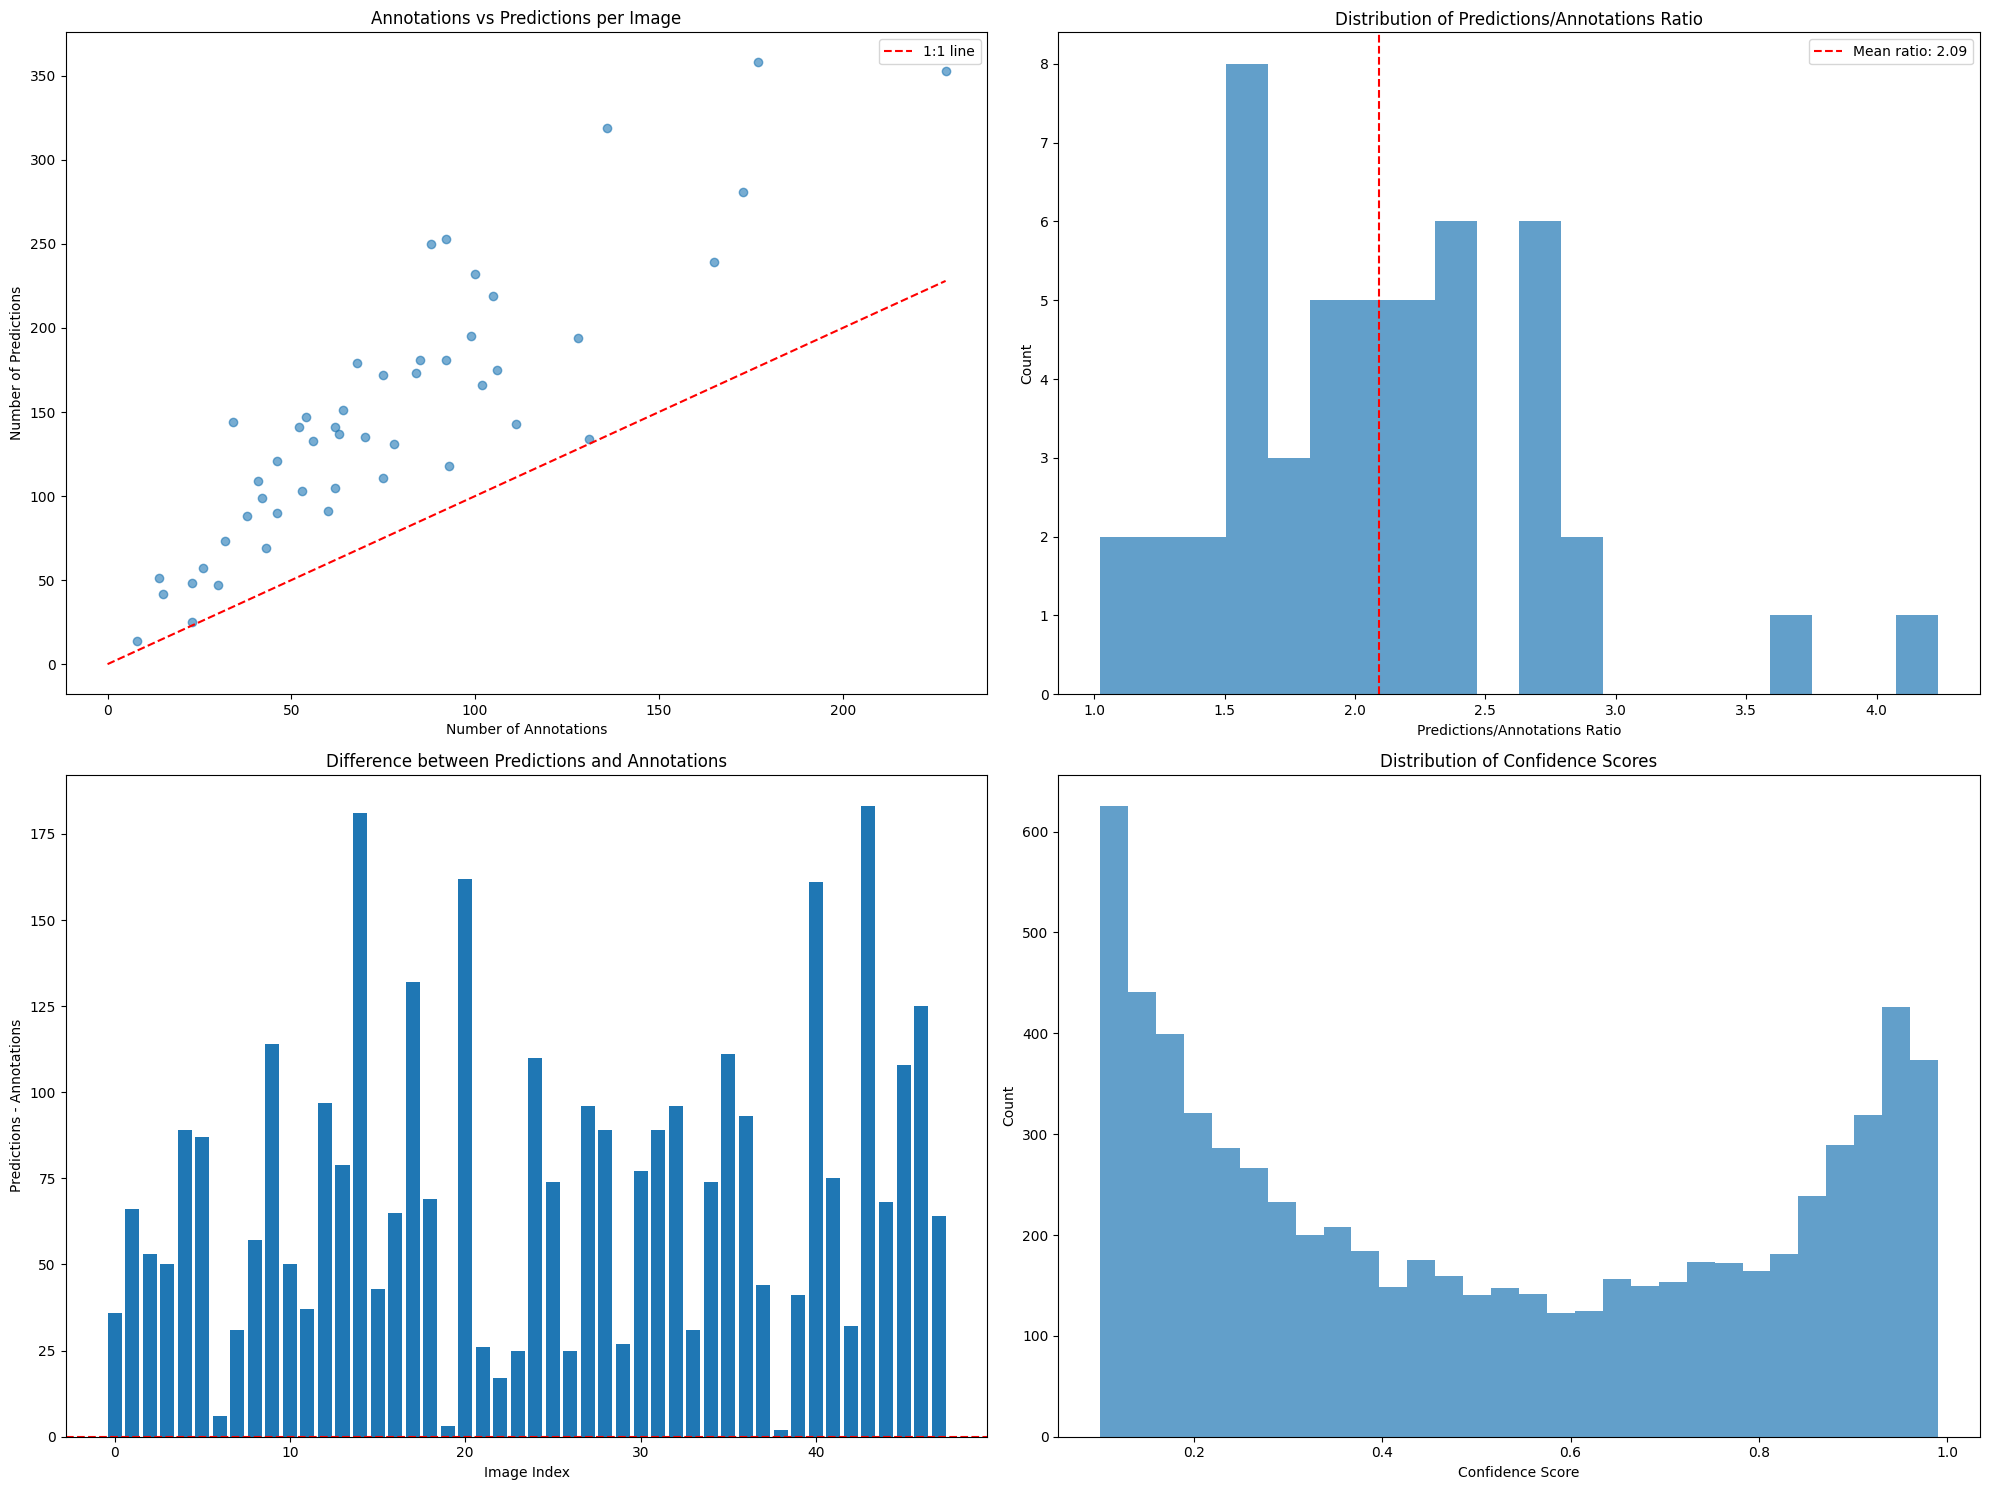

=== Summary Statistics ===

Images in annotations but missing in predictions: []

Images in predictions but missing in annotations: []

Average predictions per annotation: 1.95

Predictions/Annotations ratio per image:
count    48.000000
mean      2.092407
std       0.612115
min       1.022901
25%       1.626658
50%       2.072619
75%       2.357701
max       4.235294
dtype: float64

Confidence score statistics:
count    7118.000000
mean        0.512246
std         0.302539
min         0.100062
25%         0.218224
50%         0.468183
75%         0.820323
max         0.990468
Name: confidence, dtype: float64

Correlation between number of annotations and prediction/annotation ratio: -0.385


,annotations,predictions
image_id,,
624,75,111
627,128,194
631,78,131
645,53,103
646,92,181


In [23]:
# Count annotations and predictions per image
image_counts = pd.DataFrame({
    'annotations': anno_df.groupby('image_id').size(),
    'predictions': pred_df.groupby('image_id').size()
})

# Create figure with multiple subplots
fig = plt.figure(figsize=(20, 15))

# 1. Scatter plot: Annotations vs Predictions per image
plt.subplot(2, 2, 1)
plt.scatter(image_counts['annotations'], image_counts['predictions'], alpha=0.6)
plt.plot([0, image_counts['annotations'].max()], [0, image_counts['annotations'].max()], 
         'r--', label='1:1 line')
plt.xlabel('Number of Annotations')
plt.ylabel('Number of Predictions')
plt.title('Annotations vs Predictions per Image')
plt.legend()

# 2. Distribution of prediction/annotation ratio
plt.subplot(2, 2, 2)
ratio = image_counts['predictions'] / image_counts['annotations']
plt.hist(ratio, bins=20, alpha=0.7)
plt.axvline(ratio.mean(), color='r', linestyle='--', label=f'Mean ratio: {ratio.mean():.2f}')
plt.xlabel('Predictions/Annotations Ratio')
plt.ylabel('Count')
plt.title('Distribution of Predictions/Annotations Ratio')
plt.legend()

# 3. Bar plot: Difference between predictions and annotations
plt.subplot(2, 2, 3)
difference = image_counts['predictions'] - image_counts['annotations']
plt.bar(range(len(difference)), difference)
plt.xlabel('Image Index')
plt.ylabel('Predictions - Annotations')
plt.title('Difference between Predictions and Annotations')
plt.axhline(y=0, color='r', linestyle='--')

# 4. Confidence score distribution by match status
plt.subplot(2, 2, 4)
plt.hist(pred_df['confidence'], bins=30, alpha=0.7)
plt.xlabel('Confidence Score')
plt.ylabel('Count')
plt.title('Distribution of Confidence Scores')

plt.tight_layout()
plt.show()

# Summary statistics
print("=== Summary Statistics ===")
print(f"\nImages in annotations but missing in predictions: {image_counts[image_counts['predictions'].isnull()].index.values}")
print(f"\nImages in predictions but missing in annotations: {image_counts[image_counts['annotations'].isnull()].index.values}")

print(f"\nAverage predictions per annotation: {len(pred_df)/len(anno_df):.2f}")
print("\nPredictions/Annotations ratio per image:")
print(ratio.describe())
print("\nConfidence score statistics:")
print(pred_df['confidence'].describe())

# Calculate correlation between number of annotations and prediction accuracy
correlation = image_counts['annotations'].corr(ratio)
print(f"\nCorrelation between number of annotations and prediction/annotation ratio: {correlation:.3f}")

image_counts.head()

#### **Polygon Area Analysis**

- Overall Area Distribution:
    - Annotations:
        - Mean: 1,119.51 pixels²
        - Median: 1,007.29 pixels²
        - Range: 78.25 - 8,254.21 pixels²
    - Predictions:
        - Mean: 1,113.63 pixels² (very close to annotations)
        - Median: 963.80 pixels²
        - Range: 19.60 - 15,479.32 pixels²
- Size Consistency:
    - Mean ratio (Pred/Anno): 0.99 (excellent overall match)
    - Median ratio: 0.96
    - Only 0.8% of predictions fall outside annotation area range
    - Predictions have slightly higher variability (std: 831.58 vs 740.19)

**Notable Insights**

- Some predictions are too small (min 19.60 vs 78.25)
- Some predictions are too large (max 15,479 vs 8,254)
- Overall size distribution is well-maintained
- Slight tendency to predict smaller defects

**Recommendations**

This analysis suggests that while the model generally predicts defect sizes accurately, there are some improvements that could be made:

- Size Constraints:
    - Implement minimum size threshold (≥78 pixels²)
    - Add maximum size constraint (≤8,254 pixels²)
    - Consider size-aware confidence scoring
- Area-based Post-processing:
    - Filter out extremely small predictions (<78 pixels²)
    - Review very large predictions (>8,254 pixels²)
    - Use area as an additional confidence factor

/var/folders/jn/0b_xwd412532nmd6152zbw1w0000gp/T/ipykernel_37437/1664204105.py:57: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Annotations', 'Predictions'])


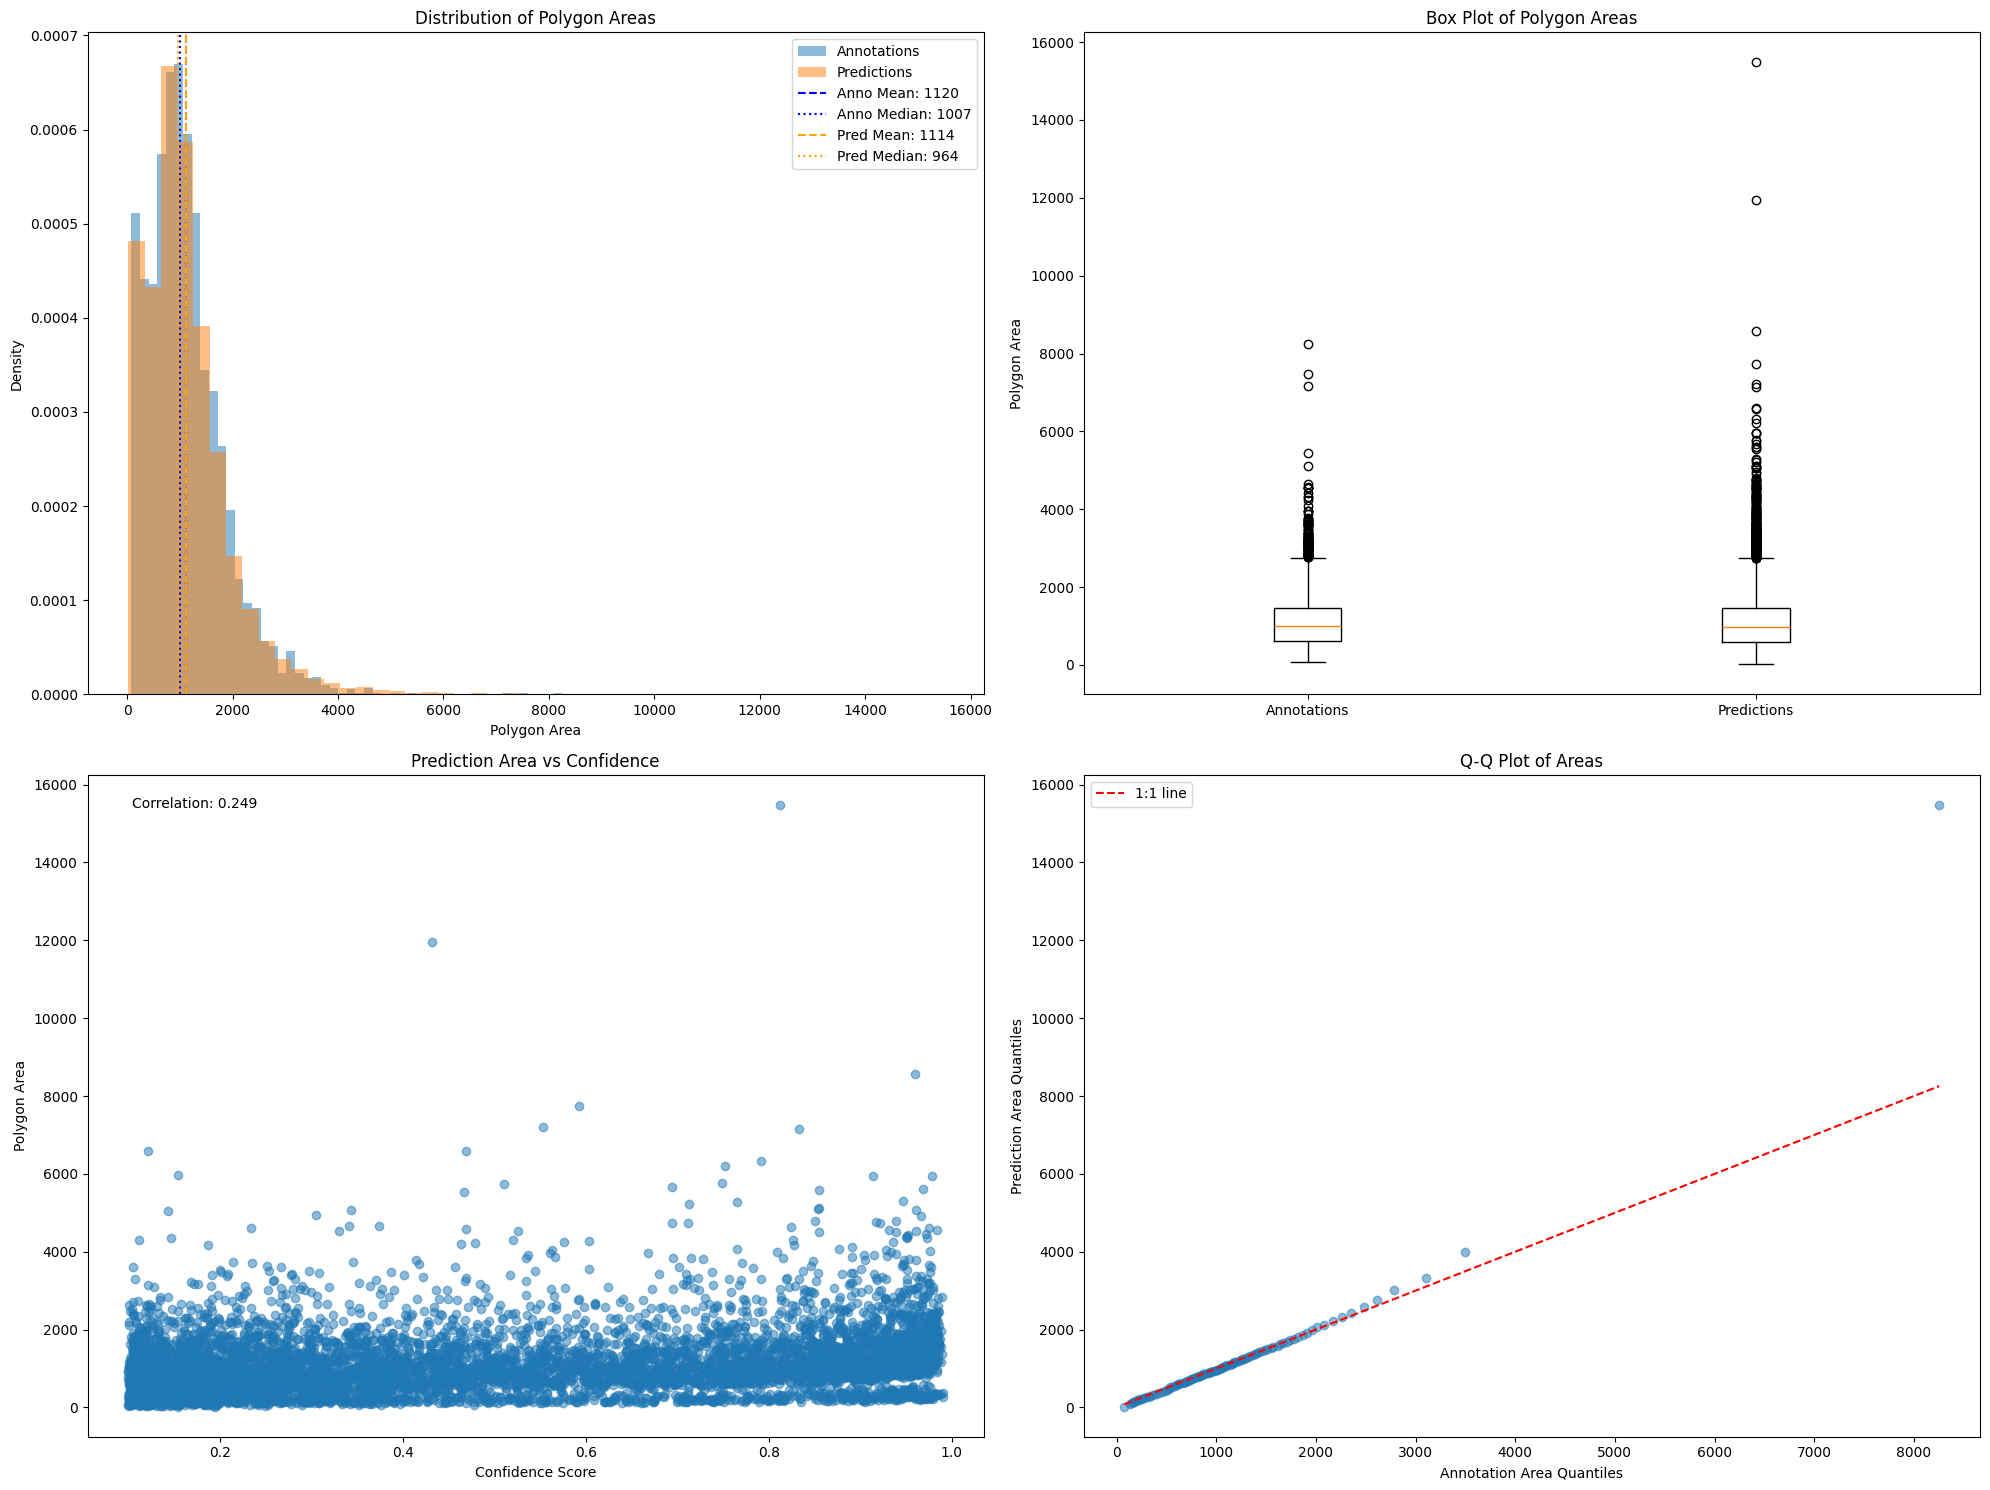

=== Polygon Area Analysis ===

Annotation Areas:
Count: 3588
Mean: 1119.51
Median: 1007.29
Std: 740.19
Min: 78.25
Max: 8254.21

Prediction Areas:
Count: 7118
Mean: 1113.63
Median: 963.80
Std: 831.58
Min: 19.60
Max: 15479.32

Predictions outside annotation area range: 54 (0.8%)

Area Ratio Analysis (Prediction/Annotation):
Mean ratio: 0.99
Median ratio: 0.96


In [24]:
def calculate_polygon_area(coords):
    """Calculate area of a polygon"""
    try:
        poly = Polygon(coords)
        return poly.area if poly.is_valid else None
    except:
        return None

# Calculate areas
anno_areas = []
pred_areas = []

for _, row in anno_df.iterrows():
    coords = parse_coordinates(row['xy'])
    if coords:
        area = calculate_polygon_area(coords)
        if area is not None:
            anno_areas.append(area)

for _, row in pred_df.iterrows():
    coords = parse_coordinates(row['xy'])
    if coords:
        area = calculate_polygon_area(coords)
        if area is not None:
            pred_areas.append(area)

# Convert to numpy arrays
anno_areas = np.array(anno_areas)
pred_areas = np.array(pred_areas)

# Create figure with multiple plots
plt.figure(figsize=(20, 15))

# 1. Distribution comparison (histogram)
plt.subplot(2, 2, 1)
plt.hist(anno_areas, bins=50, alpha=0.5, label='Annotations', density=True)
plt.hist(pred_areas, bins=50, alpha=0.5, label='Predictions', density=True)
plt.xlabel('Polygon Area')
plt.ylabel('Density')
plt.title('Distribution of Polygon Areas')
plt.legend()

# Add mean and median lines
plt.axvline(np.mean(anno_areas), color='blue', linestyle='--', 
            label=f'Anno Mean: {np.mean(anno_areas):.0f}')
plt.axvline(np.median(anno_areas), color='blue', linestyle=':',
            label=f'Anno Median: {np.median(anno_areas):.0f}')
plt.axvline(np.mean(pred_areas), color='orange', linestyle='--',
            label=f'Pred Mean: {np.mean(pred_areas):.0f}')
plt.axvline(np.median(pred_areas), color='orange', linestyle=':',
            label=f'Pred Median: {np.median(pred_areas):.0f}')
plt.legend()

# 2. Box plot comparison
plt.subplot(2, 2, 2)
data = [anno_areas, pred_areas]
plt.boxplot(data, labels=['Annotations', 'Predictions'])
plt.ylabel('Polygon Area')
plt.title('Box Plot of Polygon Areas')

# 3. Area vs Confidence (for predictions)
plt.subplot(2, 2, 3)
plt.scatter(pred_df['confidence'], pred_areas, alpha=0.5)
plt.xlabel('Confidence Score')
plt.ylabel('Polygon Area')
plt.title('Prediction Area vs Confidence')

# Calculate correlation
area_conf_corr = np.corrcoef(pred_df['confidence'], pred_areas)[0, 1]
plt.text(0.05, 0.95, f'Correlation: {area_conf_corr:.3f}', 
         transform=plt.gca().transAxes)

# 4. QQ plot to compare distributions
plt.subplot(2, 2, 4)
anno_quantiles = np.percentile(anno_areas, np.linspace(0, 100, 100))
pred_quantiles = np.percentile(pred_areas, np.linspace(0, 100, 100))
plt.scatter(anno_quantiles, pred_quantiles, alpha=0.5)
plt.plot([min(anno_areas), max(anno_areas)], 
         [min(anno_areas), max(anno_areas)], 
         'r--', label='1:1 line')
plt.xlabel('Annotation Area Quantiles')
plt.ylabel('Prediction Area Quantiles')
plt.title('Q-Q Plot of Areas')
plt.legend()

plt.tight_layout()
plt.show()

# Print statistical analysis
print("=== Polygon Area Analysis ===")

print("\nAnnotation Areas:")
print(f"Count: {len(anno_areas)}")
print(f"Mean: {np.mean(anno_areas):.2f}")
print(f"Median: {np.median(anno_areas):.2f}")
print(f"Std: {np.std(anno_areas):.2f}")
print(f"Min: {np.min(anno_areas):.2f}")
print(f"Max: {np.max(anno_areas):.2f}")

print("\nPrediction Areas:")
print(f"Count: {len(pred_areas)}")
print(f"Mean: {np.mean(pred_areas):.2f}")
print(f"Median: {np.median(pred_areas):.2f}")
print(f"Std: {np.std(pred_areas):.2f}")
print(f"Min: {np.min(pred_areas):.2f}")
print(f"Max: {np.max(pred_areas):.2f}")

# Calculate percentage of predictions outside annotation area range
min_anno_area = np.min(anno_areas)
max_anno_area = np.max(anno_areas)
outside_range = np.sum((pred_areas < min_anno_area) | (pred_areas > max_anno_area))
print(f"\nPredictions outside annotation area range: {outside_range} ({outside_range/len(pred_areas)*100:.1f}%)")

# Area ratio analysis
print("\nArea Ratio Analysis (Prediction/Annotation):")
print(f"Mean ratio: {np.mean(pred_areas)/np.mean(anno_areas):.2f}")
print(f"Median ratio: {np.median(pred_areas)/np.median(anno_areas):.2f}")

### **Defect Distribution in Images**
**Overall Distribution:**
- Annotations:
    - Mean: 76 defects per image
    - Range: 8 to 228 defects
    - High variation (std: 46.5)
- Predictions:
    - Mean: 148 defects per image
    - Range: 14 to 358 defects
    - Even higher variation (std: 80.0)
- Prediction/Annotation Ratio:
    - Mean ratio: 2.09 (about twice as many predictions as annotations)
    - Minimum ratio: 1.02 (model never under-predicts)
    - Maximum ratio: 4.24 (some severe over-prediction cases)
    - 54.2% of images have more than 2x predictions than annotations
- Notable Cases:
    - Most over-predicted images:
        - Image 2014: 4.24x more predictions
        - Image 1195: 3.64x more predictions
    - Most accurately predicted images:
        - Image 1479: 1.02x ratio
        - Image 2323: 1.09x ratio
- Class Distribution:
    - Annotations: All defects are class 7 ("Mononukleäre Zelle")
    - Predictions: All predictions are labeled as "Defect"
   
**Key Insights:**
- The model consistently over-predicts across all images
- No cases of under-prediction (ratio < 1)
- Strong correlation between number of annotations and predictions
- Prediction counts scale roughly linearly with annotation counts
- This analysis suggests that:
    - The model needs better calibration to reduce false positives
    - Over-prediction is systematic but varies in severity across images
    - The model's behavior is consistent (always over-predicts) but the degree varies

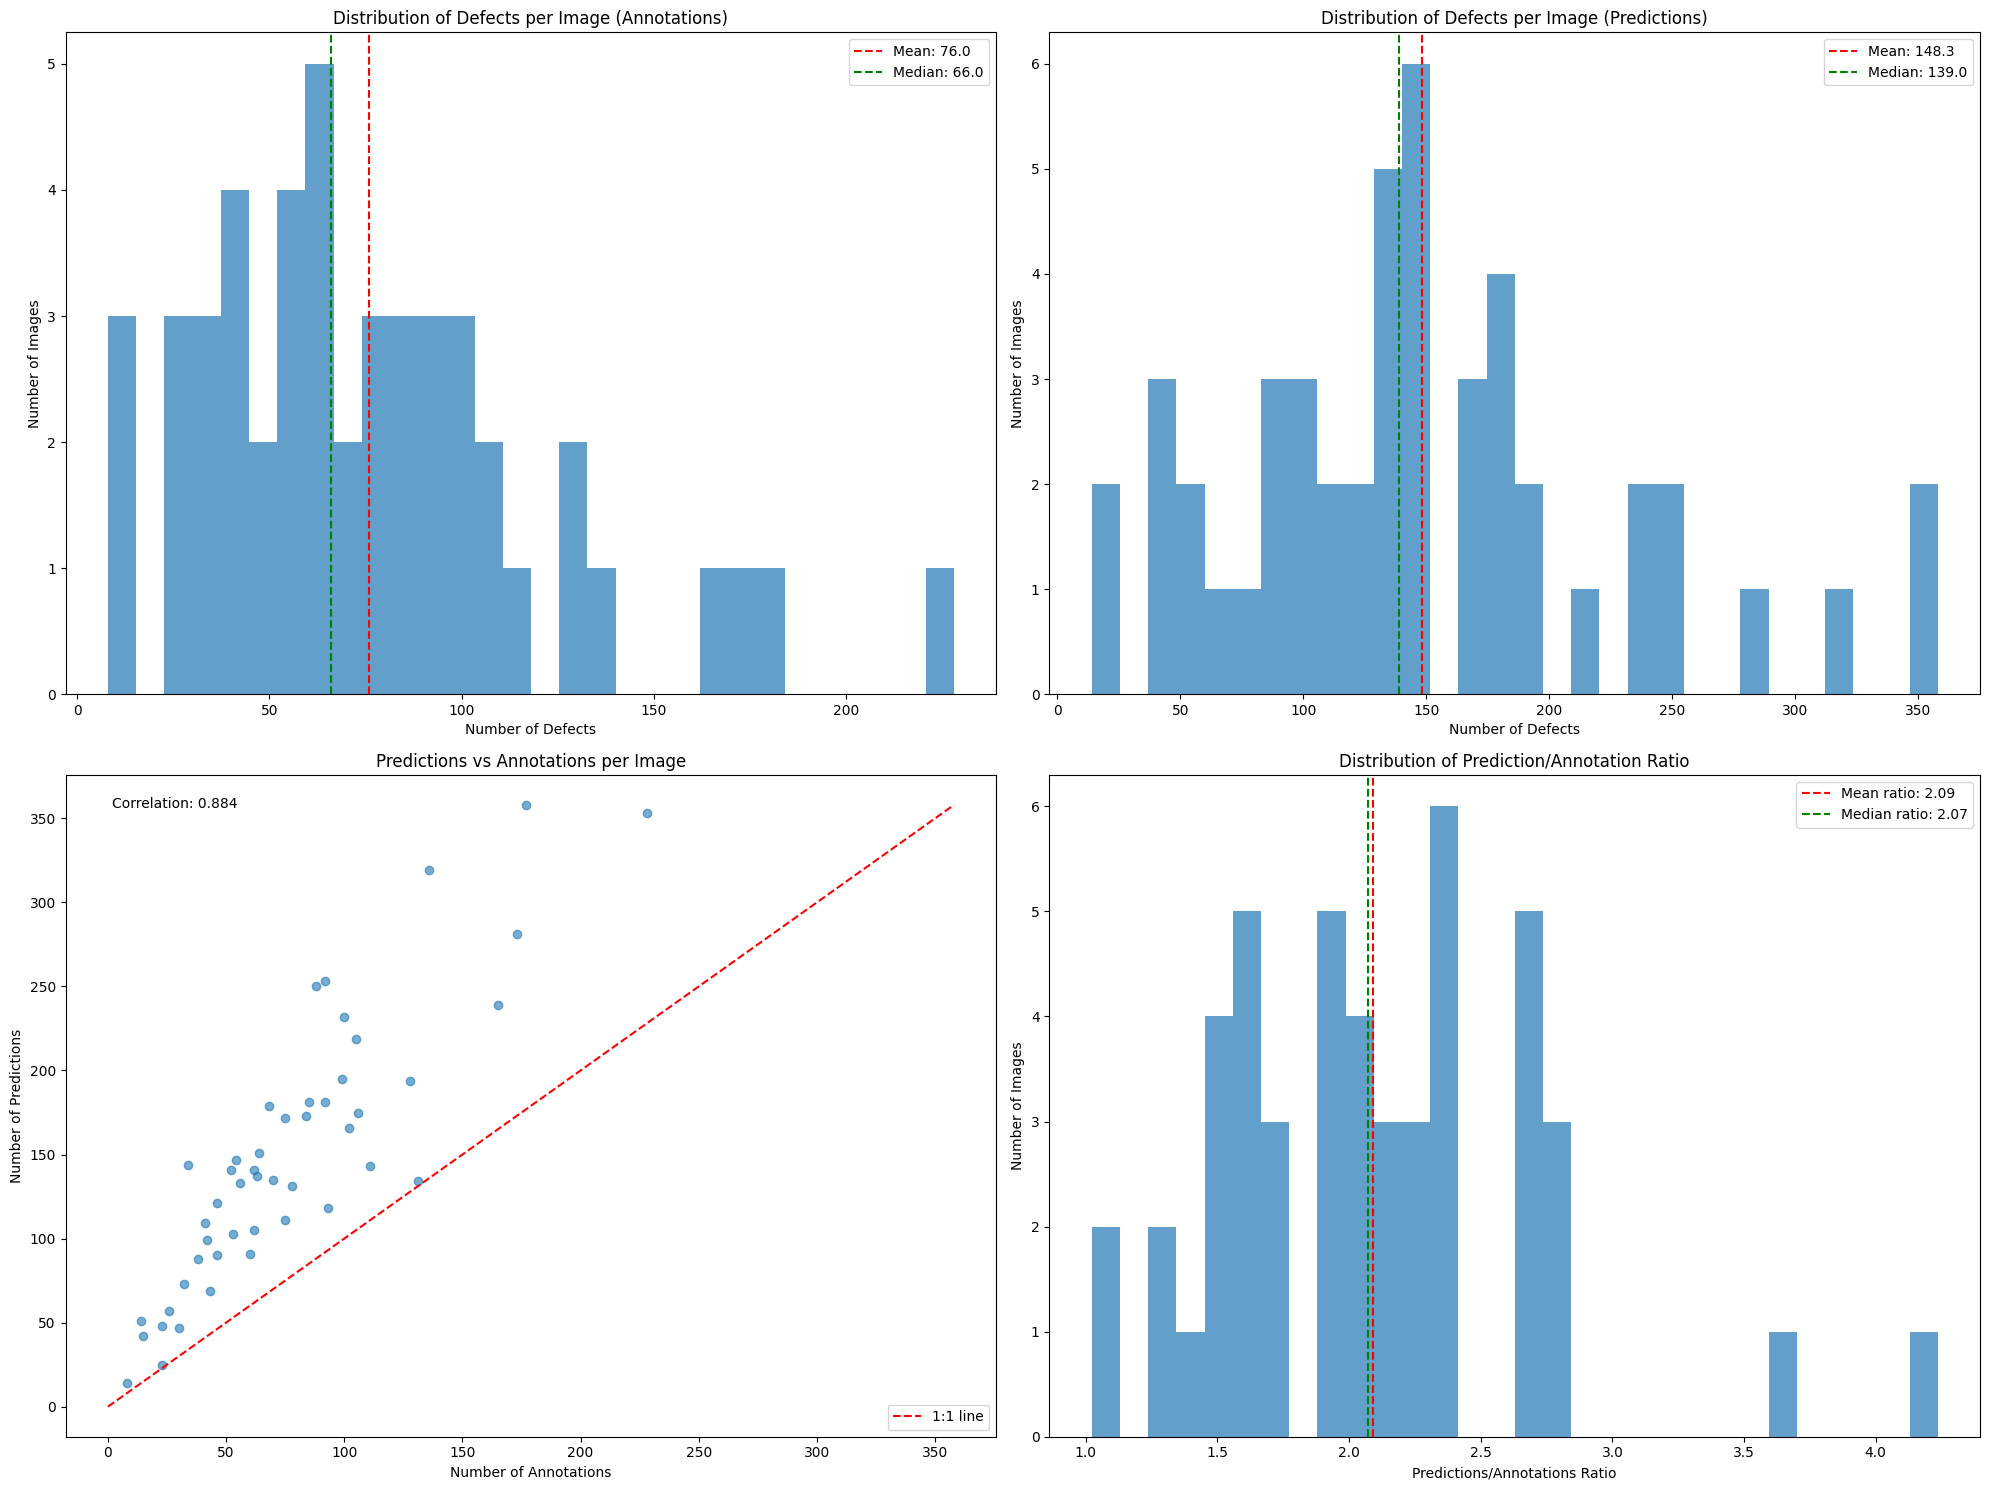

=== Defect Distribution Analysis ===

Prediction/Annotation Ratio Statistics:
count    48.000000
mean      2.092407
std       0.612115
min       1.022901
25%       1.626658
50%       2.072619
75%       2.357701
max       4.235294
dtype: float64

Over/Under Prediction Analysis:
Images with ratio > 2: 26 (54.2%)
Images with ratio < 1: 0 (0.0%)

Images with most similar prediction counts:
Image 1479: 1.02x ratio
Image 2323: 1.09x ratio
Image 2039: 1.27x ratio
Image 2876: 1.29x ratio
Image 2021: 1.45x ratio


In [25]:
# Create figure with multiple subplots
plt.figure(figsize=(20, 15))

# 1. Distribution of defects per image in annotations
plt.subplot(2, 2, 1)
anno_per_image = anno_df.groupby('image_id').size()
plt.hist(anno_per_image, bins=30, alpha=0.7)
plt.axvline(anno_per_image.mean(), color='r', linestyle='--', 
            label=f'Mean: {anno_per_image.mean():.1f}')
plt.axvline(anno_per_image.median(), color='g', linestyle='--', 
            label=f'Median: {anno_per_image.median():.1f}')
plt.xlabel('Number of Defects')
plt.ylabel('Number of Images')
plt.title('Distribution of Defects per Image (Annotations)')
plt.legend()

# 2. Distribution of defects per image in predictions
plt.subplot(2, 2, 2)
pred_per_image = pred_df.groupby('image_id').size()
plt.hist(pred_per_image, bins=30, alpha=0.7)
plt.axvline(pred_per_image.mean(), color='r', linestyle='--', 
            label=f'Mean: {pred_per_image.mean():.1f}')
plt.axvline(pred_per_image.median(), color='g', linestyle='--', 
            label=f'Median: {pred_per_image.median():.1f}')
plt.xlabel('Number of Defects')
plt.ylabel('Number of Images')
plt.title('Distribution of Defects per Image (Predictions)')
plt.legend()

# 3. Comparison of defect counts per image
plt.subplot(2, 2, 3)
plt.scatter(anno_per_image, pred_per_image, alpha=0.6)
max_val = max(anno_per_image.max(), pred_per_image.max())
plt.plot([0, max_val], [0, max_val], 'r--', label='1:1 line')
plt.xlabel('Number of Annotations')
plt.ylabel('Number of Predictions')
plt.title('Predictions vs Annotations per Image')
plt.legend()

# Calculate correlation
correlation = anno_per_image.corr(pred_per_image)
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=plt.gca().transAxes)

# 4. Ratio of predictions to annotations per image
plt.subplot(2, 2, 4)
ratio = pred_per_image / anno_per_image
plt.hist(ratio, bins=30, alpha=0.7)
plt.axvline(ratio.mean(), color='r', linestyle='--', 
            label=f'Mean ratio: {ratio.mean():.2f}')
plt.axvline(ratio.median(), color='g', linestyle='--', 
            label=f'Median ratio: {ratio.median():.2f}')
plt.xlabel('Predictions/Annotations Ratio')
plt.ylabel('Number of Images')
plt.title('Distribution of Prediction/Annotation Ratio')
plt.legend()

plt.tight_layout()
plt.show()

# Print detailed statistics
print("=== Defect Distribution Analysis ===")

print("\nPrediction/Annotation Ratio Statistics:")
print(ratio.describe())

# Analyze over/under prediction patterns
print("\nOver/Under Prediction Analysis:")
print(f"Images with ratio > 2: {len(ratio[ratio > 2])} ({len(ratio[ratio > 2])/len(ratio)*100:.1f}%)")
print(f"Images with ratio < 1: {len(ratio[ratio < 1])} ({len(ratio[ratio < 1])/len(ratio)*100:.1f}%)")

# Find images with extreme ratios
print("\nImages with most similar prediction counts:")
closest_to_one = ratio.sort_values(key=lambda x: abs(x-1)).head()
for img_id, r in closest_to_one.items():
    print(f"Image {img_id}: {r:.2f}x ratio")


#### **Analyze relationships between image characteristics and over-prediction rate**

- **Confidence Score Relationship:**
    - Weak negative correlation (-0.251) between average confidence and over-prediction rate
    - Higher confidence slightly correlates with lower over-prediction
    - Regression analysis shows:
        - Slope: -2.349 (decreasing over-prediction with increasing confidence)
        - Low R-squared (0.063): confidence alone explains little of the variation
        - Marginally significant (p-value: 0.085)
- **Image Complexity (Number of Annotations):**
    - Moderate negative correlation (-0.385) between number of annotations and over-prediction rate
    - Strong positive correlation (0.884) between annotations and predictions
    - Images with fewer annotations tend to have higher over-prediction rates
    - The model maintains relative proportions better in complex images
- **Confidence Level Patterns:**
    - Very Low confidence bin:
        - Highest mean over-prediction rate (2.42)
        - Highest variability (std: 0.56)
    - Medium confidence bin:
        - Lowest mean over-prediction rate (1.90)
        - More consistent predictions
- **Key Patterns:**
    - Over-prediction is more severe in images with:
        - Fewer annotations
        - Lower confidence scores
        - Less complex defect patterns
    - More accurate predictions occur in images with:
        - More annotations
        - Medium to high confidence
        - More complex defect patterns
- **Recommendations:**
    - Focus model improvements on images with fewer defects
    - Consider implementing confidence thresholds based on image complexity
    - Investigate why the model over-predicts more in simpler images
    - Use annotation count as a potential factor in confidence calibration

Image metrics created and saved to data/image_metrics.csv


/var/folders/jn/0b_xwd412532nmd6152zbw1w0000gp/T/ipykernel_37437/734886135.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=metrics_df['confidence_bin'].unique())


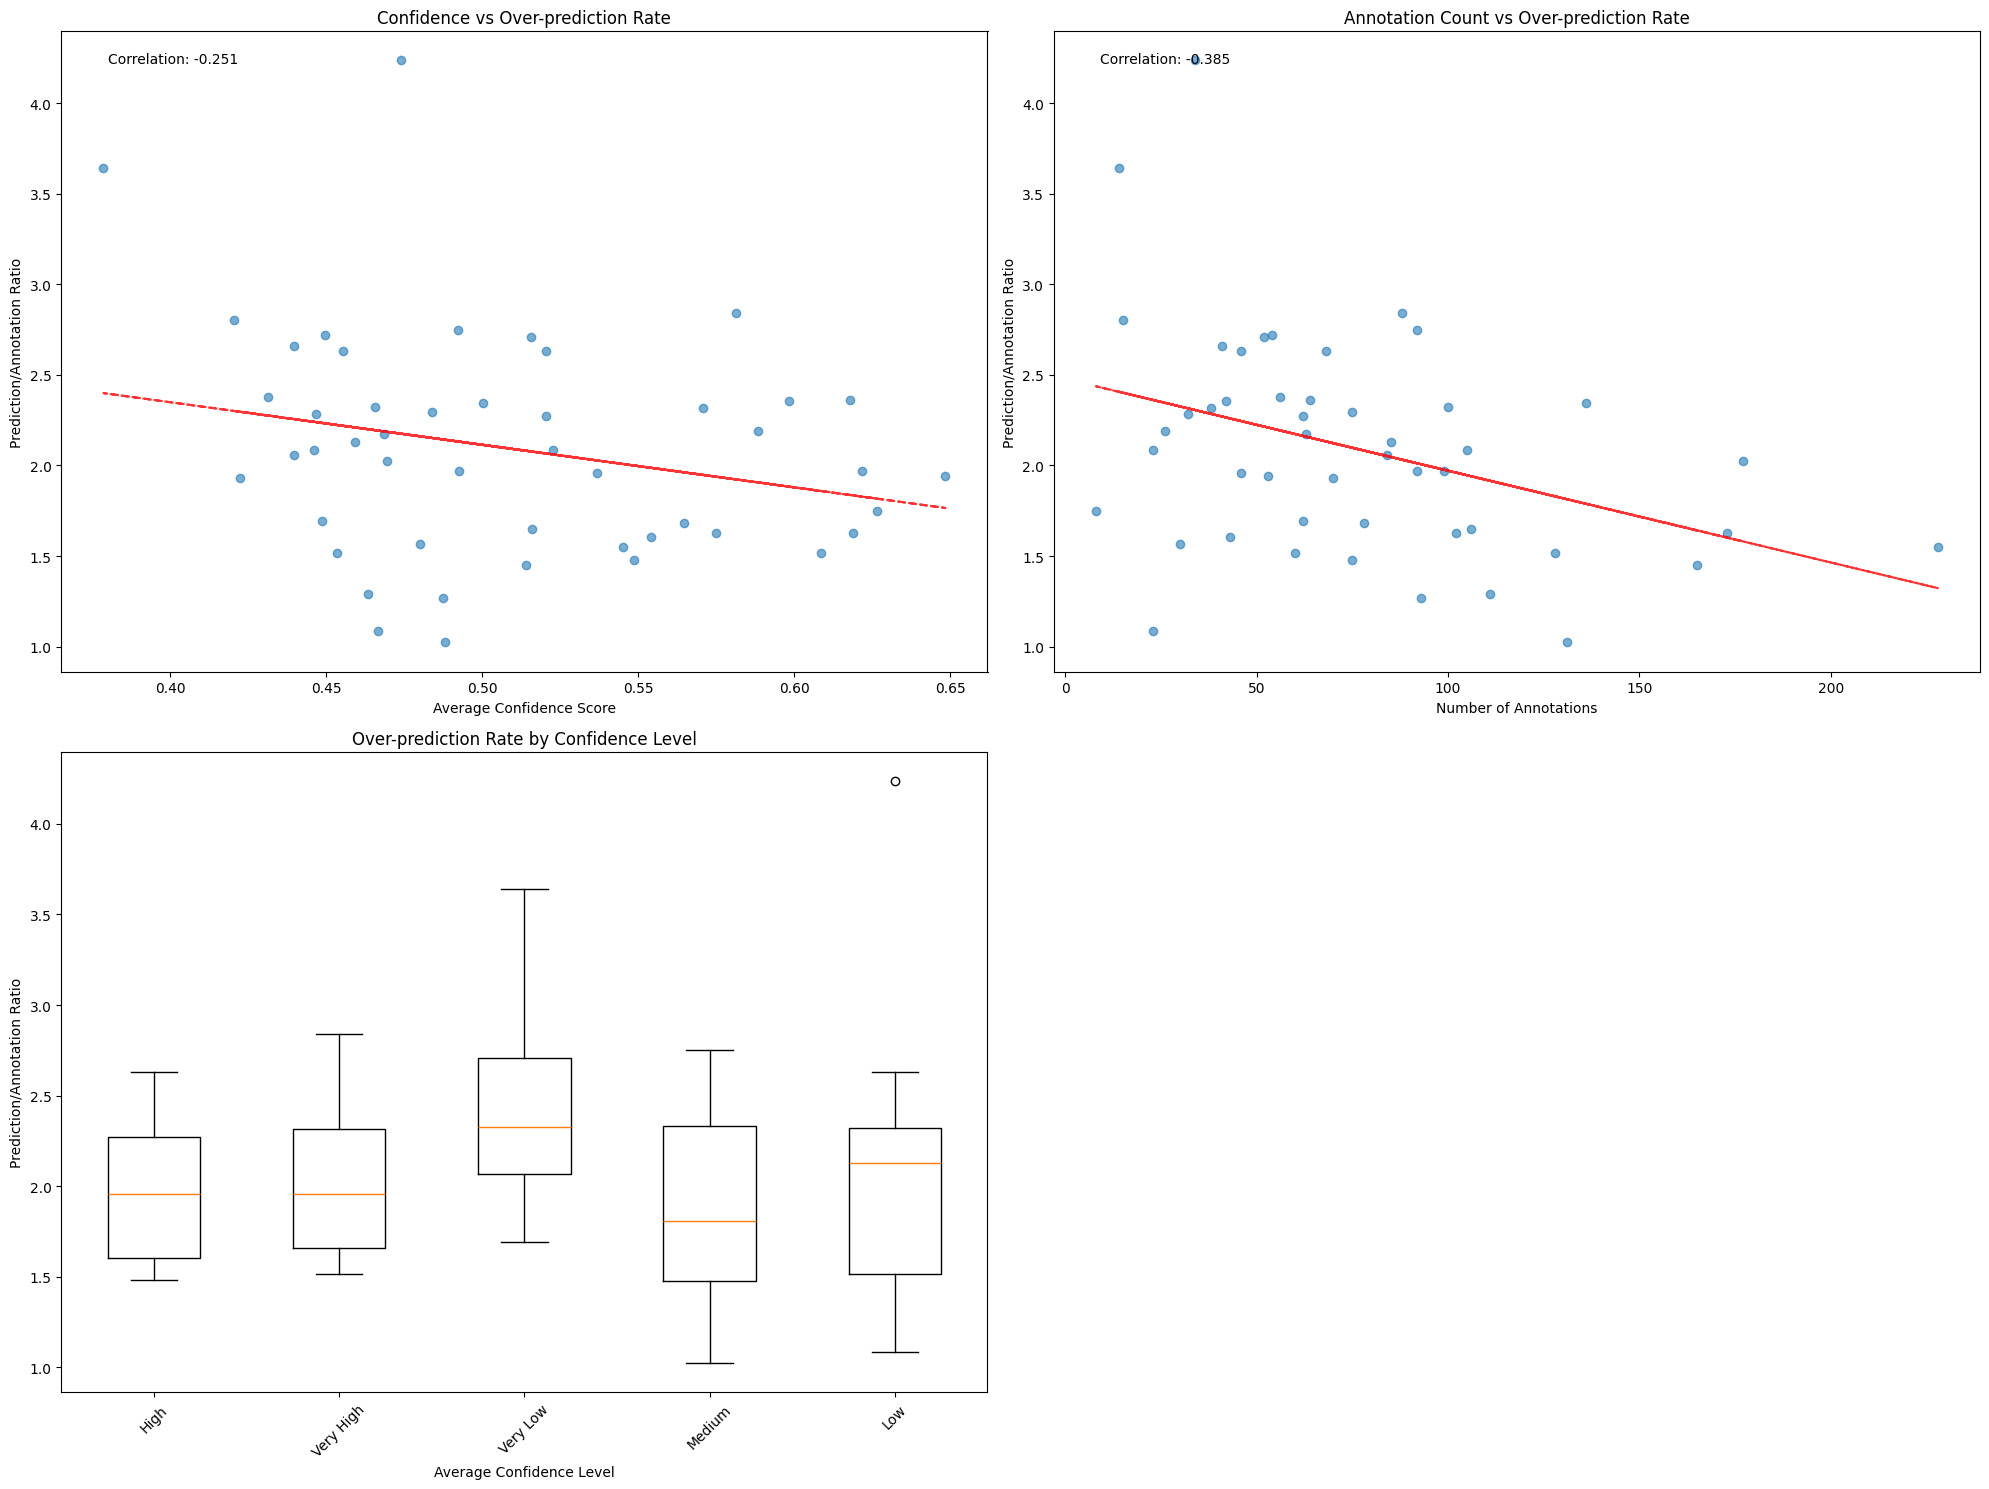

=== Statistical Analysis of Prediction Patterns ===


Correlation Analysis:
Confidence vs Over-prediction: -0.251
Annotations vs Over-prediction: -0.385
Annotations vs Predictions: 0.884

Over-prediction Rate by Confidence Level:
                count      mean       std       min       25%       50%  \
confidence_bin                                                            
Very Low         10.0  2.424847  0.559678  1.693548  2.066382  2.328125   
Low               9.0  2.156241  0.928752  1.086957  1.516667  2.129412   
Medium           10.0  1.902797  0.604045  1.022901  1.478030  1.810320   
High              9.0  1.952782  0.402342  1.480000  1.604651  1.956522   
Very High        10.0  2.017788  0.418860  1.515625  1.658088  1.955394   

                     75%       max  
confidence_bin                      
Very Low        2.706301  3.642857  
Low             2.320000  4.235294  
Medium          2.332525  2.750000  
High            2.274194  2.630435  
Very High       2.3159

/var/folders/jn/0b_xwd412532nmd6152zbw1w0000gp/T/ipykernel_37437/734886135.py:67: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(metrics_df.groupby('confidence_bin')['pred_anno_ratio'].describe())


In [26]:
# Read the metrics data
metrics_df = create_image_metrics(anno_df, pred_df)

# Create figure for analysis
plt.figure(figsize=(20, 15))

# 1. Relationship between average confidence and over-prediction ratio
plt.subplot(2, 2, 1)
plt.scatter(metrics_df['avg_confidence'], metrics_df['pred_anno_ratio'], alpha=0.6)
plt.xlabel('Average Confidence Score')
plt.ylabel('Prediction/Annotation Ratio')
plt.title('Confidence vs Over-prediction Rate')

# Add trend line
z = np.polyfit(metrics_df['avg_confidence'], metrics_df['pred_anno_ratio'], 1)
p = np.poly1d(z)
plt.plot(metrics_df['avg_confidence'], p(metrics_df['avg_confidence']), "r--", alpha=0.8)

# Add correlation coefficient
corr = metrics_df['avg_confidence'].corr(metrics_df['pred_anno_ratio'])
plt.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=plt.gca().transAxes)

# 2. Relationship between number of annotations and over-prediction ratio
plt.subplot(2, 2, 2)
plt.scatter(metrics_df['n_annotations'], metrics_df['pred_anno_ratio'], alpha=0.6)
plt.xlabel('Number of Annotations')
plt.ylabel('Prediction/Annotation Ratio')
plt.title('Annotation Count vs Over-prediction Rate')

# Add trend line
z = np.polyfit(metrics_df['n_annotations'], metrics_df['pred_anno_ratio'], 1)
p = np.poly1d(z)
plt.plot(metrics_df['n_annotations'], p(metrics_df['n_annotations']), "r--", alpha=0.8)

# Add correlation coefficient
corr = metrics_df['n_annotations'].corr(metrics_df['pred_anno_ratio'])
plt.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=plt.gca().transAxes)

# 4. Distribution of prediction ratios by confidence bins
plt.subplot(2, 2, 3)
metrics_df['confidence_bin'] = pd.qcut(metrics_df['avg_confidence'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
box_data = [metrics_df[metrics_df['confidence_bin'] == bin]['pred_anno_ratio'] for bin in metrics_df['confidence_bin'].unique()]
plt.boxplot(box_data, labels=metrics_df['confidence_bin'].unique())
plt.xlabel('Average Confidence Level')
plt.ylabel('Prediction/Annotation Ratio')
plt.title('Over-prediction Rate by Confidence Level')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Statistical Analysis
print("=== Statistical Analysis of Prediction Patterns ===\n")

# 1. Correlation Analysis
print("\nCorrelation Analysis:")
correlations = {
    'Confidence vs Over-prediction': metrics_df['avg_confidence'].corr(metrics_df['pred_anno_ratio']),
    'Annotations vs Over-prediction': metrics_df['n_annotations'].corr(metrics_df['pred_anno_ratio']),
    'Annotations vs Predictions': metrics_df['n_annotations'].corr(metrics_df['n_predictions'])
}
for pair, corr in correlations.items():
    print(f"{pair}: {corr:.3f}")

# 2. Confidence Level Analysis
print("\nOver-prediction Rate by Confidence Level:")
print(metrics_df.groupby('confidence_bin')['pred_anno_ratio'].describe())

# 3. Regression Analysis
slope, intercept, r_value, p_value, std_err = stats.linregress(metrics_df['avg_confidence'], metrics_df['pred_anno_ratio'])
print("\nRegression Analysis - Confidence vs Over-prediction:")
print(f"Slope: {slope:.3f}")
print(f"Intercept: {intercept:.3f}")
print(f"R-squared: {r_value**2:.3f}")
print(f"P-value: {p_value:.3f}")

### **Matching Results Analysis**
- True Positives: 3,111 (matched predictions with IoU > 0.5)
- False Positives: 4,007 (predictions that didn't match any annotation)
- False Negatives: 537 (annotations that weren't matched by any prediction)
- IoU Quality for True Positives:
    - Mean IoU: 0.79 (very good overlap)
    - Minimum IoU: 0.50 (our threshold)
    - 75% of matches have IoU > 0.75 (excellent overlap)
- Confidence Score Distribution:
    - True Positives:
        - Mean confidence: 0.71
        - Median confidence: 0.80
        - 75% have confidence > 0.53
    - False Positives:
        - Mean confidence: 0.36
        - Median confidence: 0.27
        75% have confidence < 0.51
    - True Positives have significantly higher confidence (mean: 0.71) than False Positives (mean: 0.36)
    - There's clear separation between TP and FP distributions, but with some overlap
- IoU vs Confidence Relationship:
    - There's a positive correlation between confidence and IoU for true positives
    - Higher confidence ranges tend to have slightly better IoU:
        - 0.00-0.25: Mean IoU = 0.768
        - 0.25-0.50: Mean IoU = 0.767
        - 0.50-0.75: Mean IoU = 0.779
        - 0.75-1.00: Mean IoU = 0.796
    - The improvement in IoU with confidence is modest but consistent

- Confidence Reliability:
    - The model is generally under-confident at high confidence scores
    - Mean calibration error: 0.086
    - High confidence (>0.8) predictions are very reliable:
        - At confidence ≥ 0.8: 82.5% precision
        - At confidence ≥ 0.9: 87.6% precision

- Practical Threshold Recommendations:
    - For high precision (>80%): Use threshold ≥ 0.8
    - For balanced performance: Use threshold around 0.385-0.5
    - For high recall: Use threshold around 0.2-0.3

**Insights**
- There's a clear separation in confidence scores between true and false positives
- The matching quality (IoU) for true positives is very good
- The model has a high false positive rate but good recall (few false negatives)
- The model is quite good at assigning higher confidence to true matches
- False positives tend to have lower confidence scores
- IoU quality improves with confidence, suggesting more confident predictions are more accurate
- There's a clear separation point around 0.40 confidence that optimizes the precision-recall trade-off
 - Strong separation between true and false positive confidence scores
- Confidence scores are reasonably well-calibrated
- Higher confidence consistently correlates with better precision
- The model shows good discrimination ability between correct and incorrect predictions

100%|██████████| 48/48 [06:09<00:00,  7.71s/it]


Polygon matches created and saved to data/polygon_matches.csv


/var/folders/jn/0b_xwd412532nmd6152zbw1w0000gp/T/ipykernel_37437/3897056723.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


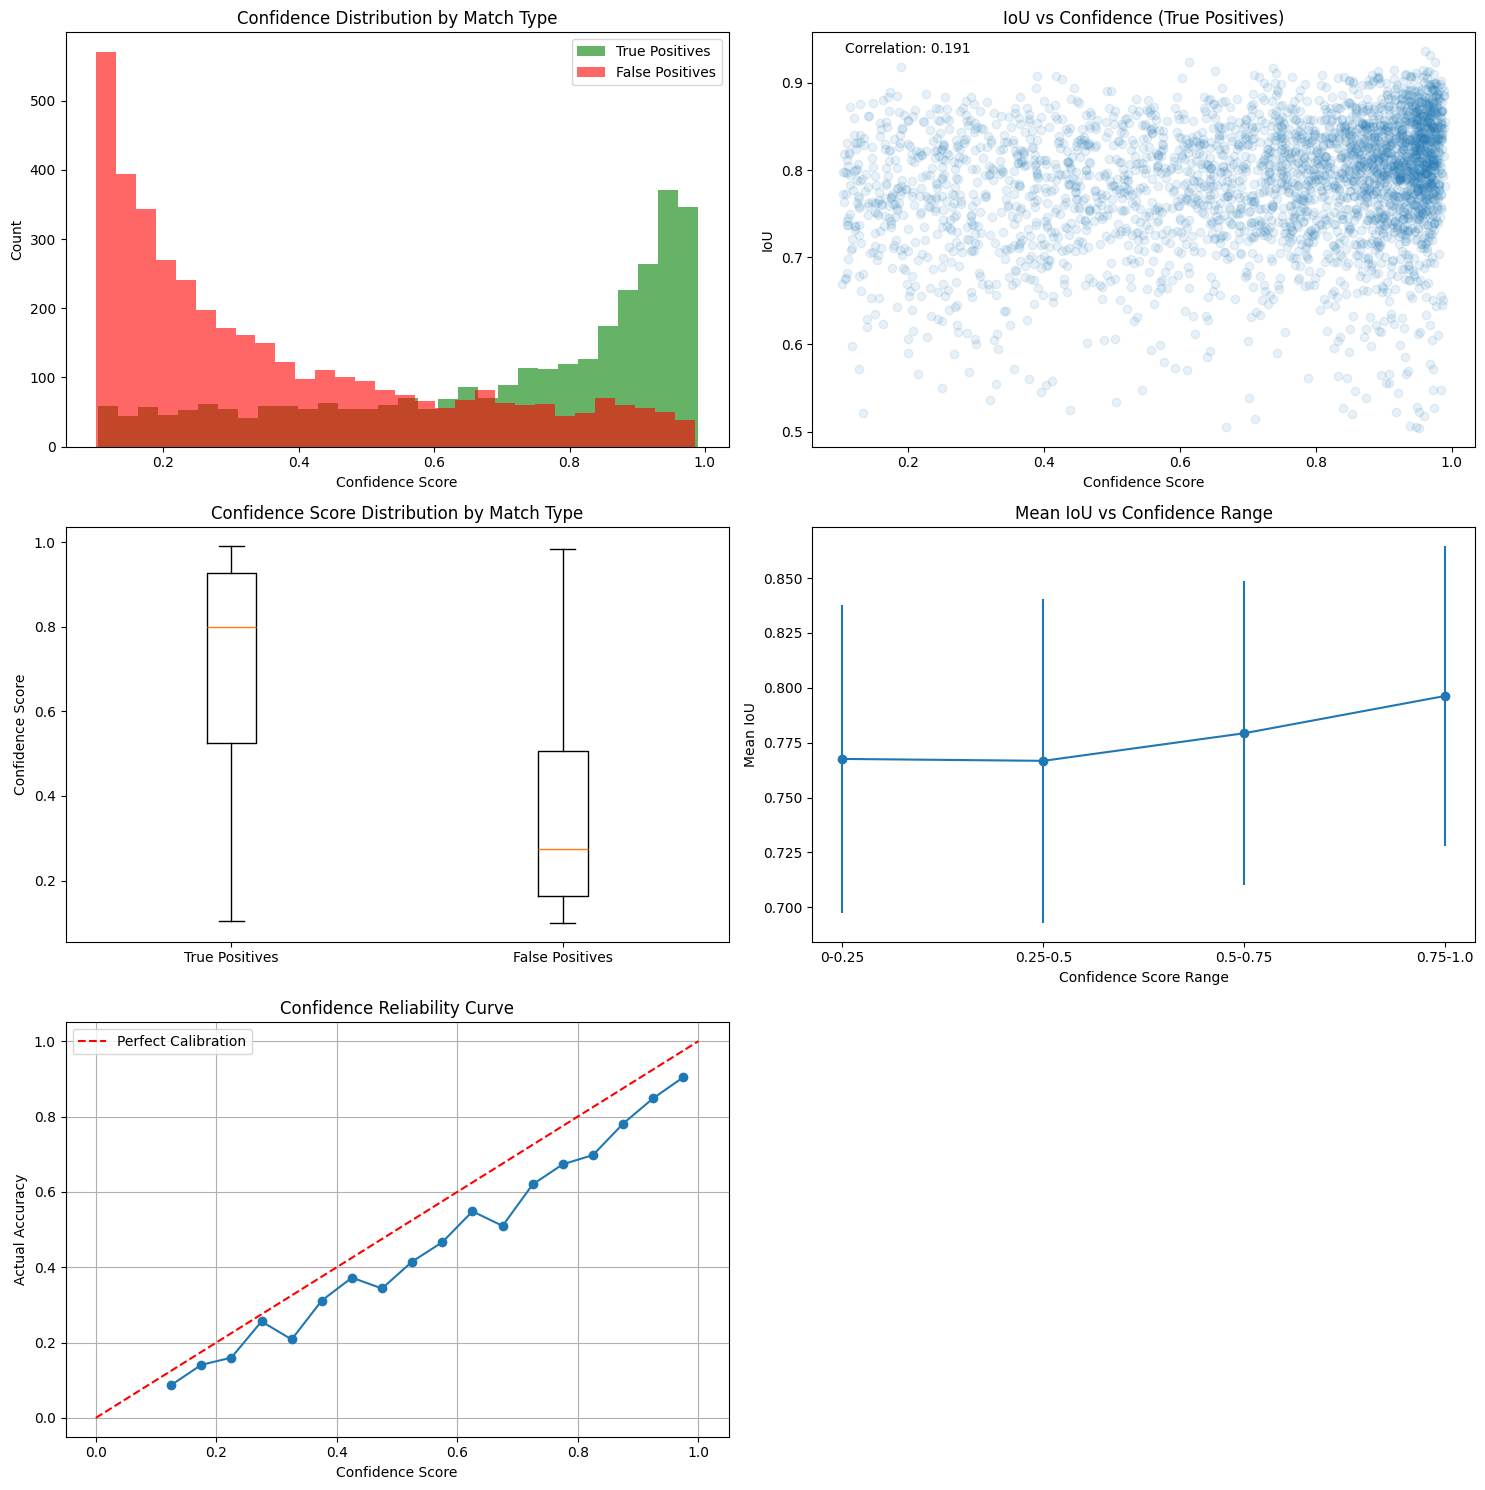


=== Matching Results ===

Match types distribution:
match_type
false_positive    4007
true_positive     3111
false_negative     537
Name: count, dtype: int64

IoU statistics for true positives:
count    3111.000000
mean        0.786008
std         0.070530
min         0.504230
25%         0.746843
50%         0.796452
75%         0.836335
max         0.936462
Name: iou, dtype: float64

Confidence score statistics for different match types:

True Positives:
count    3111.000000
mean        0.707692
std         0.257113
min         0.103593
25%         0.524616
50%         0.798733
75%         0.926508
max         0.990468
Name: confidence, dtype: float64

False Positives:
count    4007.000000
mean        0.360504
std         0.242060
min         0.100062
25%         0.162694
50%         0.274724
75%         0.506709
max         0.984827
Name: confidence, dtype: float64

Confidence Score Statistics:

True Positives:
count    3111.000000
mean        0.707692
std         0.257113
min     

In [27]:
# Match polygons with IoU threshold of 0.5
matches_df = match_polygons(anno_df, pred_df, iou_threshold=0.5)

# Create a figure with multiple subplots
plt.figure(figsize=(15, 15))

# 1. Confidence Distribution by Match Type
plt.subplot(3, 2, 1)
# True Positives
plt.hist(matches_df[matches_df['match_type'] == 'true_positive']['confidence'], 
         bins=30, alpha=0.6, label='True Positives', color='green')
# False Positives
plt.hist(matches_df[matches_df['match_type'] == 'false_positive']['confidence'], 
         bins=30, alpha=0.6, label='False Positives', color='red')
plt.xlabel('Confidence Score')
plt.ylabel('Count')
plt.title('Confidence Distribution by Match Type')
plt.legend()

# 2. IoU vs Confidence Scatter Plot (True Positives only)
plt.subplot(3, 2, 2)
tp_matches = matches_df[matches_df['match_type'] == 'true_positive']
plt.scatter(tp_matches['confidence'], tp_matches['iou'], alpha=0.1)
plt.xlabel('Confidence Score')
plt.ylabel('IoU')
plt.title('IoU vs Confidence (True Positives)')

# Calculate correlation
correlation = tp_matches['confidence'].corr(tp_matches['iou'])
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
         transform=plt.gca().transAxes)

# 3. Box Plot of Confidence by Match Type
plt.subplot(3, 2, 3)
plt.boxplot([
    matches_df[matches_df['match_type'] == 'true_positive']['confidence'],
    matches_df[matches_df['match_type'] == 'false_positive']['confidence']
], labels=['True Positives', 'False Positives'])
plt.ylabel('Confidence Score')
plt.title('Confidence Score Distribution by Match Type')

# 4. IoU Distribution for Different Confidence Ranges (True Positives)
plt.subplot(3, 2, 4)
confidence_bins = [0.0, 0.25, 0.5, 0.75, 1.0]
iou_means = []
iou_stds = []
bin_centers = []

for i in range(len(confidence_bins)-1):
    mask = (tp_matches['confidence'] >= confidence_bins[i]) & \
           (tp_matches['confidence'] < confidence_bins[i+1])
    iou_means.append(tp_matches[mask]['iou'].mean())
    iou_stds.append(tp_matches[mask]['iou'].std())
    bin_centers.append((confidence_bins[i] + confidence_bins[i+1]) / 2)

plt.errorbar(bin_centers, iou_means, yerr=iou_stds, fmt='o-')
plt.xlabel('Confidence Score Range')
plt.ylabel('Mean IoU')
plt.title('Mean IoU vs Confidence Range')
plt.xticks(bin_centers, ['0-0.25', '0.25-0.5', '0.5-0.75', '0.75-1.0'])

# 5. Confidence Reliability Curve
plt.subplot(3, 2, 5)
# Calculate accuracy for different confidence bins
conf_bins = np.linspace(0, 1, 21)
bin_accuracies = []
bin_centers = []

for i in range(len(conf_bins)-1):
    mask = (matches_df['confidence'] >= conf_bins[i]) & (matches_df['confidence'] < conf_bins[i+1])
    bin_data = matches_df[mask]
    if len(bin_data) > 0:
        accuracy = len(bin_data[bin_data['match_type'] == 'true_positive']) / len(bin_data)
        bin_accuracies.append(accuracy)
        bin_centers.append((conf_bins[i] + conf_bins[i+1]) / 2)

plt.plot(bin_centers, bin_accuracies, 'o-')
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Calibration')
plt.xlabel('Confidence Score')
plt.ylabel('Actual Accuracy')
plt.title('Confidence Reliability Curve')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


# Print summary statistics
print("\n=== Matching Results ===")
print("\nMatch types distribution:")
print(matches_df['match_type'].value_counts())

print("\nIoU statistics for true positives:")
print(tp_matches['iou'].describe())

print("\nConfidence score statistics for different match types:")
print("\nTrue Positives:")
print(tp_matches['confidence'].describe())
print("\nFalse Positives:")
fp_matches = matches_df[matches_df['match_type'] == 'false_positive']
print(fp_matches['confidence'].describe())

# T-test between TP and FP confidence scores
tp_conf = matches_df[matches_df['match_type'] == 'true_positive']['confidence']
fp_conf = matches_df[matches_df['match_type'] == 'false_positive']['confidence']
t_stat, p_value = stats.ttest_ind(tp_conf, fp_conf)

print("\nConfidence Score Statistics:")
print("\nTrue Positives:")
print(tp_conf.describe())
print("\nFalse Positives:")
print(fp_conf.describe())

print(f"\nT-test between TP and FP confidence scores:")
print(f"t-statistic: {t_stat:.3f}")
print(f"p-value: {p_value:.3e}")

# IoU analysis for different confidence ranges
print("\nIoU Statistics by Confidence Range:")
for i in range(len(confidence_bins)-1):
    mask = (tp_matches['confidence'] >= confidence_bins[i]) & \
           (tp_matches['confidence'] < confidence_bins[i+1])
    iou_stats = tp_matches[mask]['iou'].describe()
    print(f"\nConfidence {confidence_bins[i]:.2f}-{confidence_bins[i+1]:.2f}:")
    print(f"Count: {iou_stats['count']:.0f}")
    print(f"Mean IoU: {iou_stats['mean']:.3f}")
    print(f"Std IoU: {iou_stats['std']:.3f}")

# Calibration analysis
print("\nCalibration Analysis:")
for i in range(len(bin_centers)):
    print(f"\nConfidence bin {bin_centers[i]:.2f}:")
    print(f"Actual accuracy: {bin_accuracies[i]:.3f}")
    print(f"Calibration error: {abs(bin_accuracies[i] - bin_centers[i]):.3f}")

### **Calculate Optimal Confidence Threshold**

Since, Missing defects (false negatives) can lead to quality issues and Too many false alarms (false positives) waste inspection resources, Maximum F1 threshold provides the best compromise for real-world application. However, there is a slightly littel difference between 10, 100 and 1000 threshold candidates.

- Optimal Thresholds:
    - Maximum F1 Score (Best Overall Performance):
        - Threshold: 0.385
        - Precision: 0.648 (65% of predictions are correct)
        - Recall: 0.715 (71% of actual defects are found)
        - F1 Score: 0.680
    - High Precision Setting:
        - Threshold: 0.744
        - Precision: 0.800 (80% of predictions are correct)
        - Recall: 0.490 (49% of actual defects are found)
        - F1 Score: 0.607
- Trade-offs:
    - Lower thresholds (< 0.385):
        - Higher recall but more false positives
        - Good for applications where missing defects is costly
    - Higher thresholds (> 0.744):
        - Higher precision but more missed defects
        - Good for applications where false alarms are costly
- Recommendations:
    - For balanced performance: Use threshold = 0.385
    - For high-confidence predictions: Use threshold = 0.744
    - The choice depends on the relative cost of false positives vs. false negatives
- Additional Insights:
    - The precision-recall curve shows a smooth trade-off
    - There's a significant drop in recall above 0.75 confidence
    - The model maintains decent precision even at lower thresholds

100%|██████████| 10/10 [00:00<00:00, 91.58it/s]



=== Optimal Thresholds Analysis at Threshold Candidate: 10 ===


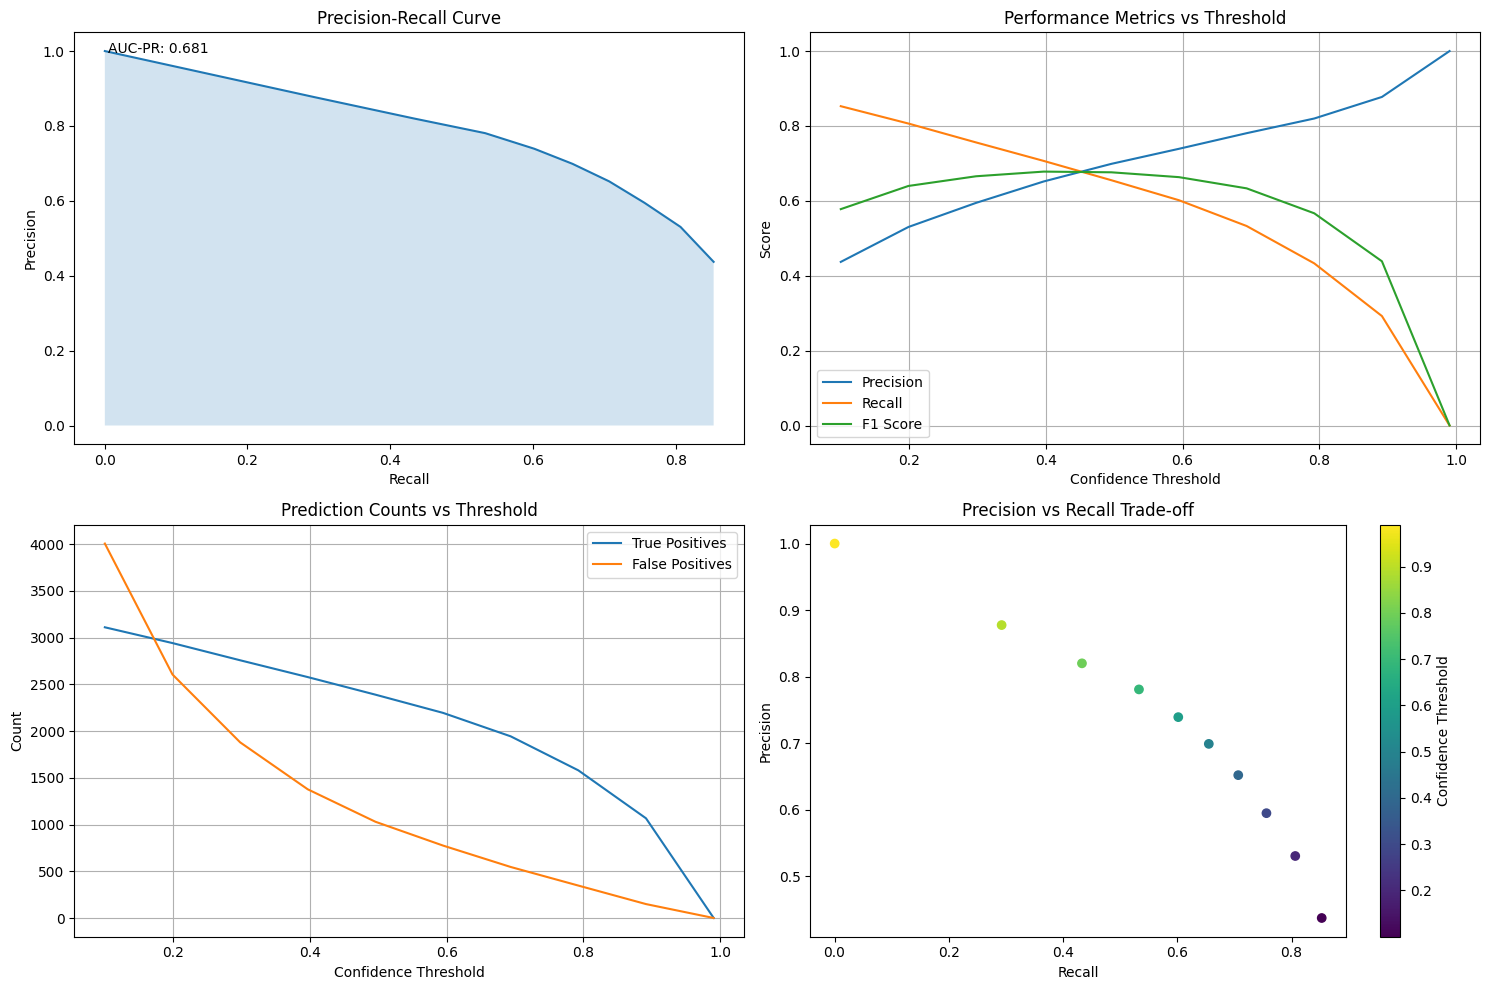


Recommended confidence threshold (based on F1 score): 0.40
F1 score at this threshold: 0.678

1. Maximum F1 Score:
Threshold: 0.397
Precision: 0.652
Recall: 0.707
F1 Score: 0.678

2. Balanced Precision-Recall:
Threshold: 0.496
Precision: 0.699
Recall: 0.655
F1 Score: 0.676

3. High Precision (>=0.8):
Threshold: 0.793
Precision: 0.820
Recall: 0.433
F1 Score: 0.567


100%|██████████| 100/100 [00:01<00:00, 63.06it/s]



=== Optimal Thresholds Analysis at Threshold Candidate: 100 ===


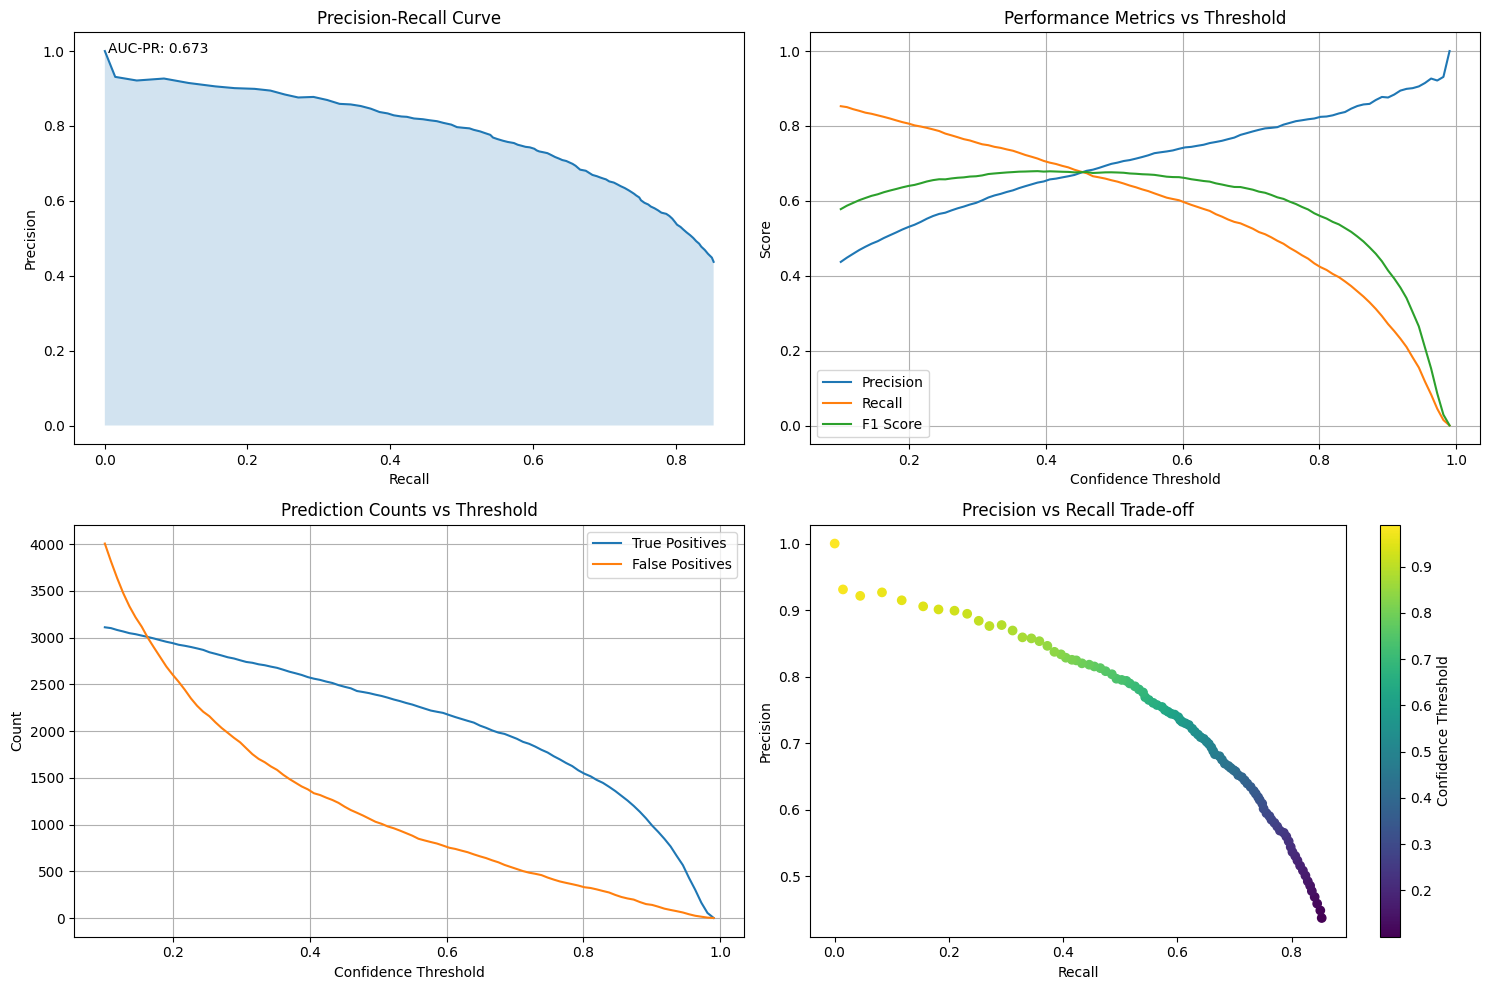


Recommended confidence threshold (based on F1 score): 0.39
F1 score at this threshold: 0.679

1. Maximum F1 Score:
Threshold: 0.388
Precision: 0.649
Recall: 0.713
F1 Score: 0.679

2. Balanced Precision-Recall:
Threshold: 0.451
Precision: 0.675
Recall: 0.678
F1 Score: 0.677

3. High Precision (>=0.8):
Threshold: 0.748
Precision: 0.804
Recall: 0.485
F1 Score: 0.605


100%|██████████| 1000/1000 [00:19<00:00, 52.23it/s]



=== Optimal Thresholds Analysis at Threshold Candidate: 1000 ===


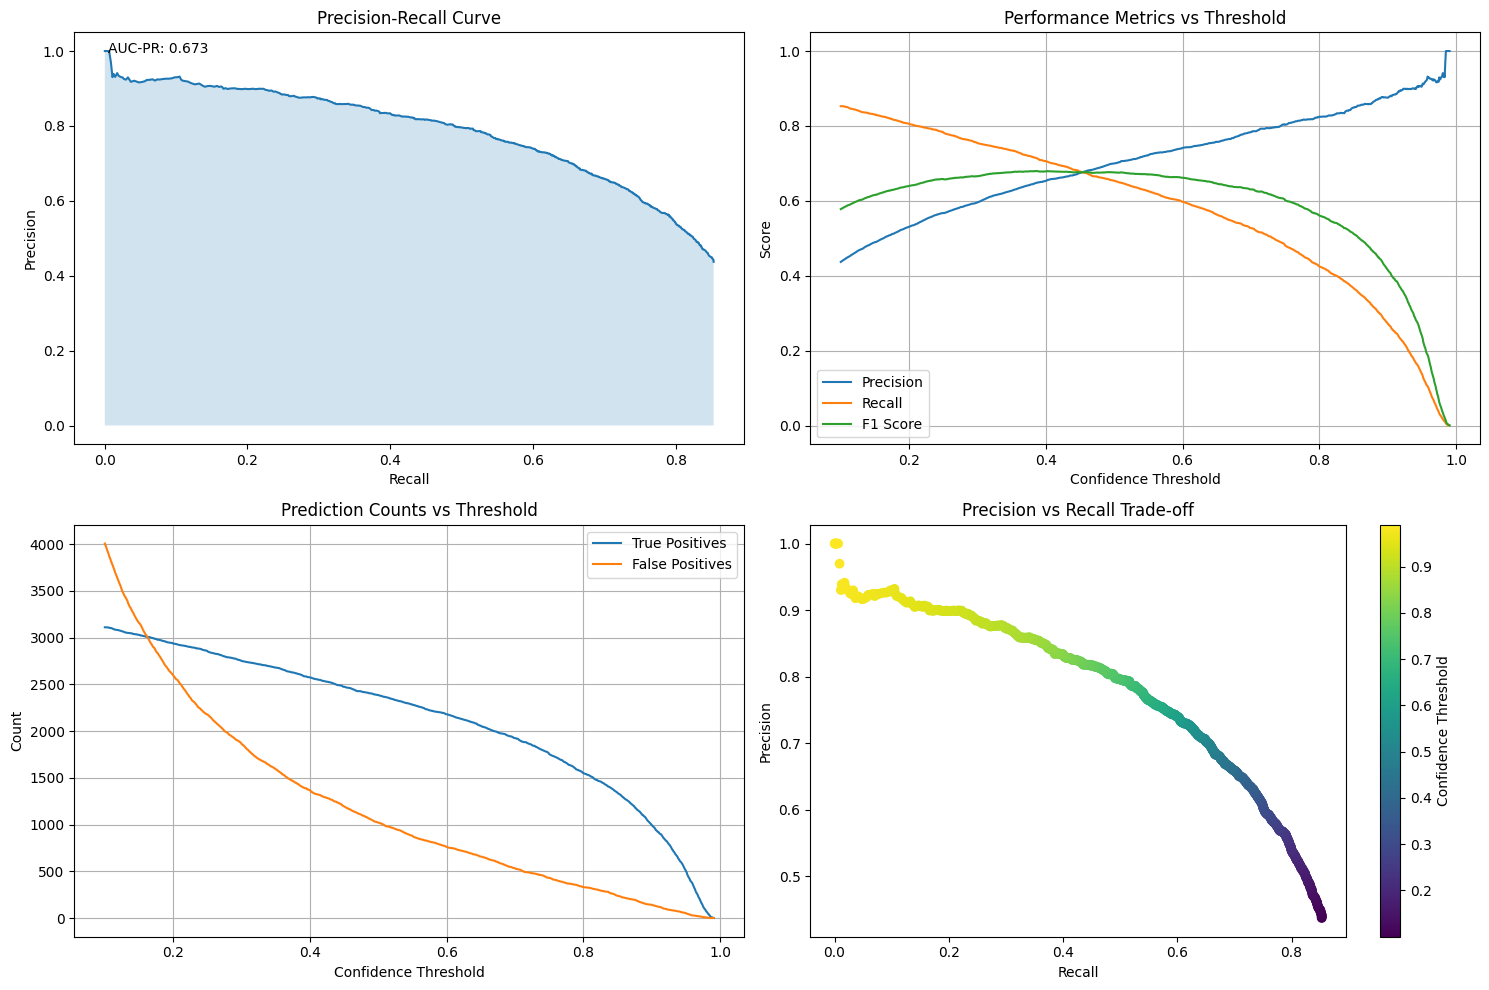


Recommended confidence threshold (based on F1 score): 0.39
F1 score at this threshold: 0.680

1. Maximum F1 Score:
Threshold: 0.385
Precision: 0.648
Recall: 0.715
F1 Score: 0.680

2. Balanced Precision-Recall:
Threshold: 0.453
Precision: 0.676
Recall: 0.676
F1 Score: 0.676

3. High Precision (>=0.8):
Threshold: 0.744
Precision: 0.800
Recall: 0.490
F1 Score: 0.607


In [28]:
# Calculate optimal confidence threshold based on F1 score
threshold_candidates = [10, 100, 1000]

def test_threshold_with_candidates(threshold_candidate):
    """Evaluate model performance at a given confidence threshold"""

    # The predictions have confidence scores ranging from 0.10 to 0.99
    thresholds = np.linspace(pred_df['confidence'].min(), pred_df['confidence'].max(), threshold_candidate)
    best_f1 = 0
    best_threshold = 0

    def evaluate_threshold(confidence_threshold):
        """Evaluate model performance at a given confidence threshold"""

        # True Positives at this threshold
        tp = len(matches_df[(matches_df['match_type'] == 'true_positive') & 
                        (matches_df['confidence'] >= threshold)])
        # False Positives at this threshold
        fp = len(matches_df[(matches_df['match_type'] == 'false_positive') & 
                        (matches_df['confidence'] >= threshold)])
        # False Negatives (true positives below threshold + original false negatives)
        fn = len(matches_df[(matches_df['match_type'] == 'true_positive') & 
                        (matches_df['confidence'] < threshold)]) + \
            len(matches_df[matches_df['match_type'] == 'false_negative'])
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        return precision, recall, f1, tp, fp, fn

    # Find the optimal thrsholds and Calculate metrics for different thresholds
    threshold_results = []
    for threshold in tqdm(thresholds):
        precision, recall, f1, tp, fp, fn = evaluate_threshold(threshold)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

        threshold_results.append({
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'tp': tp,
            'fp': fp,
            'fn': fn
        })

    threshold_results_df = pd.DataFrame(threshold_results)
    print("\n=== Optimal Thresholds Analysis at Threshold Candidate: {} ===".format(threshold_candidate))
    # Create figure with multiple subplots
    plt.figure(figsize=(15, 10))

    # 1. Precision-Recall Curve
    plt.subplot(2, 2, 1)
    plt.plot(threshold_results_df['recall'], threshold_results_df['precision'])
    plt.fill_between(threshold_results_df['recall'], threshold_results_df['precision'], alpha=0.2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    # Calculate AUC-PR
    pr_auc = auc(threshold_results_df['recall'], threshold_results_df['precision'])
    plt.text(0.05, 0.95, f'AUC-PR: {pr_auc:.3f}', transform=plt.gca().transAxes)

    # 2. Metrics vs Threshold
    plt.subplot(2, 2, 2)
    plt.plot(threshold_results_df['threshold'], threshold_results_df['precision'], label='Precision')
    plt.plot(threshold_results_df['threshold'], threshold_results_df['recall'], label='Recall')
    plt.plot(threshold_results_df['threshold'], threshold_results_df['f1'], label='F1 Score')
    plt.xlabel('Confidence Threshold')
    plt.ylabel('Score')
    plt.title('Performance Metrics vs Threshold')
    plt.legend()
    plt.grid(True)

    # 3. True/False Positives vs Threshold
    plt.subplot(2, 2, 3)
    plt.plot(threshold_results_df['threshold'], threshold_results_df['tp'], label='True Positives')
    plt.plot(threshold_results_df['threshold'], threshold_results_df['fp'], label='False Positives')
    plt.xlabel('Confidence Threshold')
    plt.ylabel('Count')
    plt.title('Prediction Counts vs Threshold')
    plt.legend()
    plt.grid(True)

    # 4. Precision vs Recall trade-off
    plt.subplot(2, 2, 4)
    plt.scatter(threshold_results_df['recall'], threshold_results_df['precision'], 
            c=threshold_results_df['threshold'], cmap='viridis')
    plt.colorbar(label='Confidence Threshold')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision vs Recall Trade-off')

    plt.tight_layout()
    plt.show()

    print(f"\nRecommended confidence threshold (based on F1 score): {best_threshold:.2f}")
    print(f"F1 score at this threshold: {best_f1:.3f}")

    # Find optimal thresholds for different criteria
    max_f1_idx = threshold_results_df['f1'].idxmax()
    balanced_idx = (threshold_results_df['precision'] - threshold_results_df['recall']).abs().idxmin()
    high_precision_idx = threshold_results_df[threshold_results_df['precision'] >= 0.8]['f1'].idxmax()

    print("\n1. Maximum F1 Score:")
    print(f"Threshold: {threshold_results_df.loc[max_f1_idx, 'threshold']:.3f}")
    print(f"Precision: {threshold_results_df.loc[max_f1_idx, 'precision']:.3f}")
    print(f"Recall: {threshold_results_df.loc[max_f1_idx, 'recall']:.3f}")
    print(f"F1 Score: {threshold_results_df.loc[max_f1_idx, 'f1']:.3f}")

    print("\n2. Balanced Precision-Recall:")
    print(f"Threshold: {threshold_results_df.loc[balanced_idx, 'threshold']:.3f}")
    print(f"Precision: {threshold_results_df.loc[balanced_idx, 'precision']:.3f}")
    print(f"Recall: {threshold_results_df.loc[balanced_idx, 'recall']:.3f}")
    print(f"F1 Score: {threshold_results_df.loc[balanced_idx, 'f1']:.3f}")

    print("\n3. High Precision (>=0.8):")
    if not threshold_results_df[threshold_results_df['precision'] >= 0.8].empty:
        print(f"Threshold: {threshold_results_df.loc[high_precision_idx, 'threshold']:.3f}")
        print(f"Precision: {threshold_results_df.loc[high_precision_idx, 'precision']:.3f}")
        print(f"Recall: {threshold_results_df.loc[high_precision_idx, 'recall']:.3f}")
        print(f"F1 Score: {threshold_results_df.loc[high_precision_idx, 'f1']:.3f}")
    else:
        print("No threshold achieves precision >= 0.8")

    # Save results for further analysis
    threshold_results_df.to_csv(f'../data/threshold_metrics_{threshold_candidate}.csv', index=False)

for threshold_candidate in threshold_candidates:
    test_threshold_with_candidates(threshold_candidate)